In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100)

In [2]:
DATA_PATH = Path.cwd().parent / "data" / "raw"
OUTPUT_PATH = Path.cwd().parent / "models" / "submissions"

print(DATA_PATH)
print(OUTPUT_PATH)

/home/pi/workspace/drivendata.flu-shot-learning/data/raw
/home/pi/workspace/drivendata.flu-shot-learning/models/submissions


In [3]:
features_df = pd.read_csv(
    DATA_PATH / "training_set_features.csv", 
    index_col="respondent_id"
)

labels_df = pd.read_csv(
    DATA_PATH / "training_set_labels.csv", 
    index_col="respondent_id"
)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [5]:
one_hot_cols = features_df.columns[features_df.dtypes == "object"].values[0:-2]
one_hot_cols

array(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa'], dtype=object)

In [6]:
for col in one_hot_cols :
    print(col)
    print(features_df[col].value_counts(dropna=False))
    print ("\n")

age_group
65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64


education
College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
NaN                  1407
Name: education, dtype: int64


race
White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64


sex
Female    15858
Male      10849
Name: sex, dtype: int64


income_poverty
<= $75,000, Above Poverty    12777
> $75,000                     6810
NaN                           4423
Below Poverty                 2697
Name: income_poverty, dtype: int64


marital_status
Married        13555
Not Married    11744
NaN             1408
Name: marital_status, dtype: int64


rent_or_own
Own     18736
Rent     5929
NaN      2042
Name: rent_or_own, dtype: int64


employment_status
Employed              13560
Not in Labor Force    10231
NaN  

In [7]:
one_hot_cols.tolist() ## nett zu wissen, brauchen wir aber nicht ;-)

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

In [11]:
for col in pd.get_dummies(features_df, columns=one_hot_cols, dummy_na=True).columns:
    print('features_df.' + col)
    

features_df.h1n1_concern
features_df.h1n1_knowledge
features_df.behavioral_antiviral_meds
features_df.behavioral_avoidance
features_df.behavioral_face_mask
features_df.behavioral_wash_hands
features_df.behavioral_large_gatherings
features_df.behavioral_outside_home
features_df.behavioral_touch_face
features_df.doctor_recc_h1n1
features_df.doctor_recc_seasonal
features_df.chronic_med_condition
features_df.child_under_6_months
features_df.health_worker
features_df.health_insurance
features_df.opinion_h1n1_vacc_effective
features_df.opinion_h1n1_risk
features_df.opinion_h1n1_sick_from_vacc
features_df.opinion_seas_vacc_effective
features_df.opinion_seas_risk
features_df.opinion_seas_sick_from_vacc
features_df.household_adults
features_df.household_children
features_df.employment_industry
features_df.employment_occupation
features_df.age_group_18 - 34 Years
features_df.age_group_35 - 44 Years
features_df.age_group_45 - 54 Years
features_df.age_group_55 - 64 Years
features_df.age_group_65+ 

In [42]:
newfeatures_df = pd.get_dummies(features_df, columns=one_hot_cols, dummy_na=True)

#newfeatures_df.dtypes == "object"

In [45]:
numeric_cols = newfeatures_df.columns[newfeatures_df.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children' 'age_group_18 - 34 Years' 'age_group_35 - 44 Years'
 'age_group_45 - 54 Years' 'age_group_55 - 64 Years' 'age_group_65+ Years'
 'age_group_nan' 'education_12 Years' 'education_< 12 Years'
 'education_College Graduate' 'education_Some College' 'education_nan'
 'race_Black' 'race_Hispanic' 'race_Other or Multiple' 'race_White'
 'race_nan' 'sex_Female' 'sex_Male' 'sex_nan'
 'income_poverty_<= $75,000, Above Poverty' 'income_poverty_> $75,000'
 'income_pove

In [7]:
# ---------------------------------------

In [46]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

In [47]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", C=1)
)

In [48]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [49]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       '...
       'hhs_geo_region_kbazzjca', 'hhs_geo_region_lrircsnp',
       'hhs_geo_region_lzgpxyit', 'hhs_geo_region_mlyzmhmf',
       'hhs_geo_region_oxchjgsf', 'hhs_geo_region_qufhixun',
       'hhs_geo_region_nan', 'census_msa_MSA, Not Principle  City',
       'census_msa_MSA, Principle City', 'ce

In [50]:
X_train, X_eval, y_train, y_eval = train_test_split(
    newfeatures_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [51]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)
preds

CPU times: user 1.35 s, sys: 440 ms, total: 1.79 s
Wall time: 1.79 s


[array([[0.66227994, 0.33772006],
        [0.90218033, 0.09781967],
        [0.76726519, 0.23273481],
        ...,
        [0.94697536, 0.05302464],
        [0.91939971, 0.08060029],
        [0.93109056, 0.06890944]]),
 array([[0.52806788, 0.47193212],
        [0.51087285, 0.48912715],
        [0.20146812, 0.79853188],
        ...,
        [0.85580896, 0.14419104],
        [0.88744818, 0.11255182],
        [0.09625407, 0.90374593]])]

In [52]:
print("test_probas[0].shape", preds[0].shape)
print("test_probas[1].shape", preds[1].shape)

test_probas[0].shape (8814, 2)
test_probas[1].shape (8814, 2)


In [53]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6728,0.337720,0.471932
16516,0.097820,0.489127
3106,0.232735,0.798532
16981,0.732326,0.922748
19111,0.227251,0.767821


In [54]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

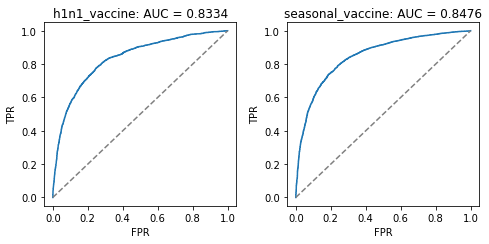

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)

plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)

fig.tight_layout()

In [57]:
roc_auc_score(y_eval, y_preds)

0.8405147425719206

In [58]:
%%time 

full_pipeline.fit(newfeatures_df, labels_df)

None   # So we don't print out the whole pipeline representation

CPU times: user 1.74 s, sys: 700 ms, total: 2.44 s
Wall time: 2.43 s


In [60]:
test_features_df = pd.read_csv(DATA_PATH / "test_set_features.csv", index_col="respondent_id")

new_test_features_df = pd.get_dummies(test_features_df, columns=one_hot_cols, dummy_na=True)

test_probas = full_pipeline.predict_proba(new_test_features_df)
test_probas

[array([[0.91058041, 0.08941959],
        [0.95310427, 0.04689573],
        [0.52220866, 0.47779134],
        ...,
        [0.8620221 , 0.1379779 ],
        [0.94472272, 0.05527728],
        [0.4251507 , 0.5748493 ]]),
 array([[0.74362951, 0.25637049],
        [0.96371938, 0.03628062],
        [0.34889758, 0.65110242],
        ...,
        [0.7924393 , 0.2075607 ],
        [0.6487271 , 0.3512729 ],
        [0.48838595, 0.51161405]])]

In [61]:
submission_df = pd.read_csv(DATA_PATH / "submission_format.csv", index_col="respondent_id")
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [62]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(new_test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.089420,0.256370
26708,0.046896,0.036281
26709,0.477791,0.651102
26710,0.484131,0.878090
26711,0.172353,0.452223


In [63]:
submission_df.to_csv(OUTPUT_PATH / 'submission_2.csv', index=True)